In [1]:
import numpy as np
import string # for stripping title punctuation for valid filenames
#from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
image_cnt = 0 #SHARON
# wanted_images = [
#     "Experiment 1 Results DRAM Network Final Performance",
#     "Experiment 1 Results DRAM Network Development",
#     "Experiment 1 Results FF Network Final Performance",
#     "Experiment 1 Results FF Network Development",
#     "Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance",
#     "Expt 2 Results fn propto 1n2 Decr Avg Area Development",
#     "Expt 2 Results fn Const Decr Avg Area Final Performance",
#     "Expt 2 Results fn Const Decr Avg Area Development"
# ] #SHARON

wanted_images = [
    "Expt 2 Results fn propto 1n2 Const Avg Area Final Performance",
    "Expt 2 Results fn propto 1n2 Const Avg Area Development",
    "Expt 2 Results fn Const Const Avg Area Final Performance",
    "Expt 2 Results fn Const Const Avg Area Development"
    "Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance",
    "Expt 2 Results fn propto 1n2 Decr Avg Area Development",
    "Expt 2 Results fn Const Decr Avg Area Final Performance",
    "Expt 2 Results fn Const Decr Avg Area Development"
] #SHARON 7/9/18

num_runs = 10
iter_list = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
glimpse_list = [0,3,9]
max_blobs = 9
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
output_size = max_blobs - min_blobs + 1
chist = np.load(data_directory + 'choice_hist.npy')[:,:,:,:10,:10] # runs, iters, glimpses, inputs, outputs
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:,:10,:]

cmus = cm[:,:,:,:,0] # mean
csds = cm[:,:,:,:,1] # sd
ccvs = cm[:,:,:,:,2] # cv

In [2]:
# take the averages across the 10 runs
chist_mu = np.mean(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [3]:
def plot_hists(matrix,i_ind):
    fig, ax = plt.subplots(12,num_glimpses,sharex=True, sharey=True,figsize=(8,16))
    x = range(1, 10)
    fig.tight_layout()
    plt.xticks(range(1, 10))
    for c in range(num_glimpses):
        for i in range(12):
            tstr = 'I = ' + str(iter_list[i]) + ', G = ' + str(glimpse_list[c])
            ax[i][c].set_title(tstr)
            ax[i][c].plot(x,matrix[i,c,:9])
    plt.show()

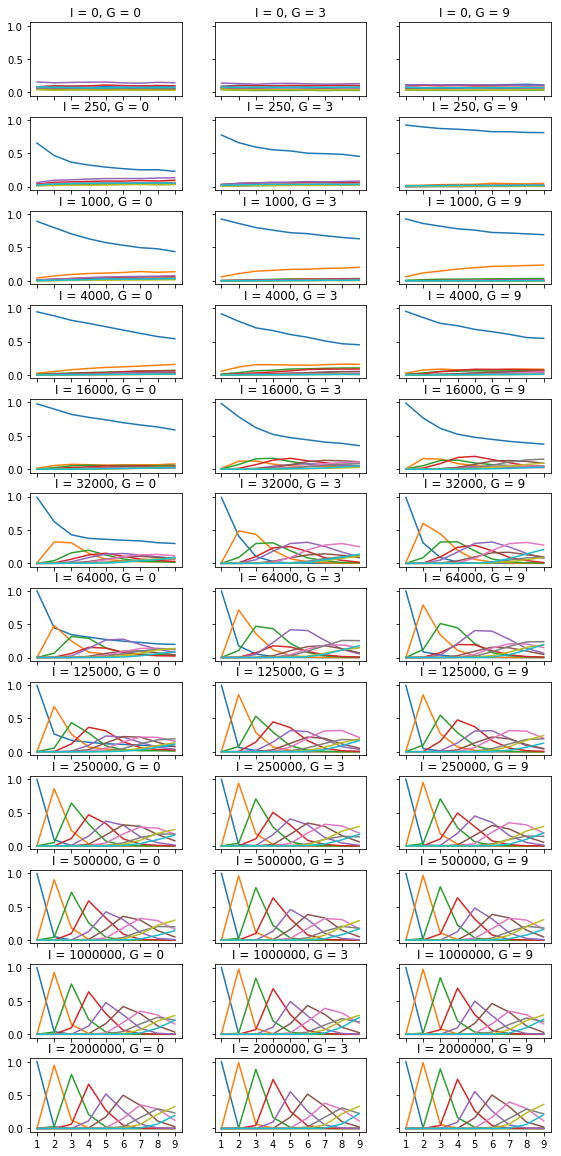

In [4]:
iter_idx = num_iters - 1
plot_hists(chist_mu,iter_idx)

## Run Linear Regression

In [5]:
import scipy.stats as st
import scipy.optimize as opt

def get_linreg(cvals,num_runs=10,eouts=range(1,max_blobs+1)):
    """Get lines of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    r_vals = np.zeros(num_runs)
    
    if num_runs is 1:
        aouts = np.array([cvals[eout-min_blobs] for eout in eouts])
        slopes, intercepts, r_vals, _, _ = st.linregress(eouts, aouts)
    else:
        for run in range(num_runs):
            aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
            slopes[run], intercepts[run], r_vals[run], _, _ = st.linregress(eouts, aouts)
    
    return slopes, intercepts, r_vals


def powfit(x, slope, intercept, power):
    y = slope * np.power(x, power) + intercept
    return y


def get_powreg(cvals,num_runs=10,eouts=range(1,max_blobs+1)):
    """Get power curve of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    powers = np.zeros(num_runs)
    
    for run in range(num_runs):
        aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
        popt, pcov = opt.curve_fit(powfit, eouts, aouts, [1,0,1], maxfev=2000)
        slopes[run], intercepts[run], powers[run] = popt

    return slopes, intercepts, powers

(10, 12, 3, 10)


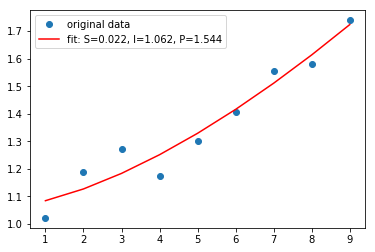

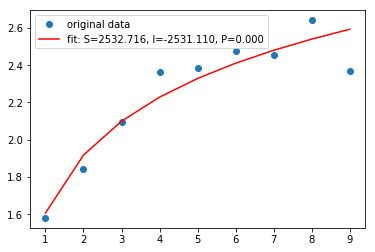

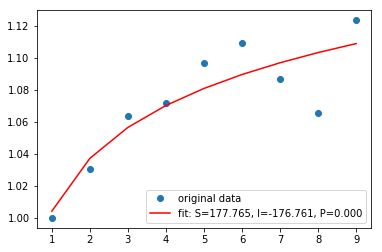

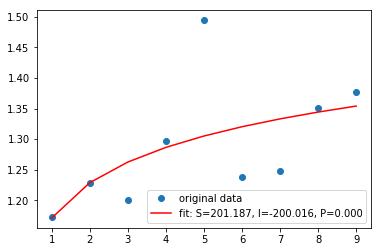

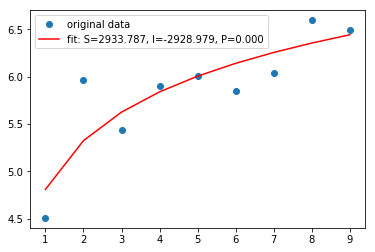

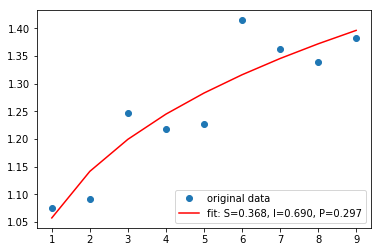

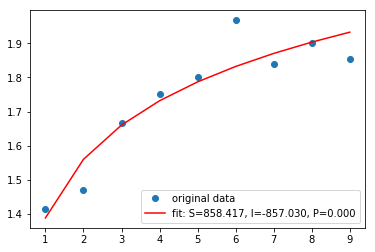

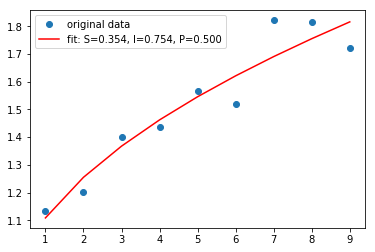

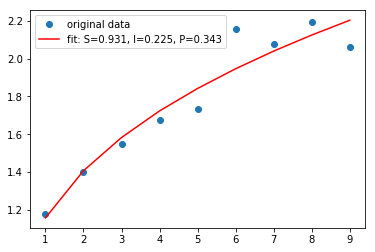

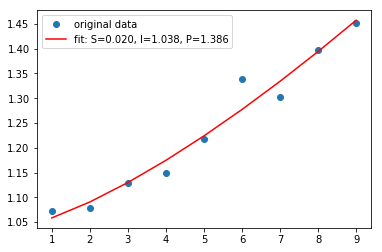

In [6]:
print(cmus.shape)

cmus_slopes, cmus_intercepts, cmus_rvals = get_linreg(cmus[:,11,2])
cmus_slopes_pow, cmus_intercepts_pow, cmus_power_pow = get_powreg(cmus[:,1,2])

csds_slopes, csds_intercepts, csds_rvals = get_linreg(csds[:,11,2])
ccvs_slopes, ccvs_intercepts, ccvs_rvals = get_linreg(ccvs[:,11,2])
ccvs_slopes_4to9, ccvs_intercepts_4to9, ccvs_rvals_4to9 = get_linreg(ccvs[:,11,2],eouts=range(4,10))
ccvs_slopes_4to9_mu, ccvs_intercepts_4to9_mu, ccvs_rvals_4to9_mu = get_linreg(ccvs_mu[11,2],num_runs=1,eouts=range(4,10))


# Visualize
for i in range(num_runs):
    plt.plot(range(1,10), cmus[i,1,2,:9], 'o', label='original data')
    plt.plot(range(1,10), powfit(range(1,10), cmus_slopes_pow[i], cmus_intercepts_pow[i], cmus_power_pow[i]), 'r-',
             label='fit: S=%5.3f, I=%5.3f, P=%5.3f' % (cmus_slopes_pow[i], cmus_intercepts_pow[i], cmus_power_pow[i]))
    plt.legend()
    plt.show()

In [7]:
import math

def get_CI(vals):
    """Get the 95% confidence intervals."""

    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(9)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 4), round(hw, 4)

# Confidence Intervals

## Mean Choice

### Slope

In [8]:
get_CI(cmus_slopes)

(0.979, 0.0177)

### Intercept

In [9]:
get_CI(cmus_intercepts)

(0.02, 0.0371)

### R-Values

In [10]:
get_CI(cmus_rvals)

(0.9997, 0.0001)

## Standard Deviation of Choice

### Slope

In [11]:
get_CI(csds_slopes)

(0.1594, 0.0073)

### Intercept

In [12]:
get_CI(csds_intercepts)

(-0.1526, 0.0186)

### R-Values

In [13]:
get_CI(csds_rvals)

(0.9894, 0.0058)

## Coefficient of Variation of Choice

### Slope

In [14]:
get_CI(ccvs_slopes)

(0.0149, 0.0008)

### Intercept

In [15]:
get_CI(ccvs_intercepts)

(0.037, 0.0061)

### R-Values

In [16]:
get_CI(ccvs_rvals)

(0.7949, 0.0326)

# Final DRAM Chart

In [17]:
x = []
for i in range(12):
    x.append(range(0,10))
    
x
x = range(max_blobs+1)

In [18]:
def plot_graph(tstr, ax, col, ylim, cvals,
               show_S=False, show_I=False, show_band=False,
               show_test_group=False, test_group=None,
               show_linreg_eq=False, show_5to9_linreg_eq=False, plot_linreg=False, plot_5to9_linreg=False, powreg=False,
               all_iters_same_row=False,
               linestyle='-', linewidth=2, move_text=False,
               show_cta_caa_avg_key=False,
               show_avg_key=False):
    """Plot a single graph."""

    # take the averages across the 10 runs
    smu = np.mean(cvals,axis=0)
    smin = np.min(cvals,axis=0)
    smax = np.max(cvals,axis=0)
    
    if not all_iters_same_row:
        ax.set_title(ax.get_title() + tstr)
        
    ax.set_ylim(bottom=0,top=ylim)
    ax.set_xlim(left=0,right=max_blobs+1)
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_ticks_position('left')
            
    slopes, intercepts, rvals = get_linreg(cvals)
    S_mean, S_hw = get_CI(slopes)
    I_mean, I_hw = get_CI(intercepts)
    R_mean, R_hw = get_CI(rvals)
        
    if show_linreg_eq:
        x_loc = .35
        y_loc = .75
        if move_text: #make sure text doesn't cross lines SHARON
            x_loc = .65
            y_loc = .25
            
        ax.text(x_loc, y_loc, 'S: $' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n I: $' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n R: $' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        

#     if show_test_group:
#         if len(tstr) > 0:
#             tstr += "\n" #Format correctly when no iter_num shown SHARON
#         tstr += test_group
    if show_cta_caa_avg_key:
        if len(tstr) > 0:
            tstr += "\n" #Format correctly when no iter_num shown SHARON
        tstr += test_group
    elif show_S:
        if len(tstr) > 0:
            tstr += "\n"
        tstr += "S=" + str(S_mean)
        

    if show_band:
        smin = np.insert(smin,0,None)
        smax = np.insert(smax,0,None)
        ax.fill_between(x,smin[:max_blobs+1],smax[:max_blobs+1], facecolor='orange')
        
       
    slopes, intercepts, rvals = get_linreg(cvals,eouts=range(5,max_blobs+1))
    S_mean, S_hw = get_CI(slopes)
    I_mean, I_hw = get_CI(intercepts)
    R_mean, R_hw = get_CI(rvals)
    
    if show_5to9_linreg_eq:
        x_loc = .55
        y_loc = .5
        if move_text:
            x_loc = .55 #make sure text doesn't cross lines SHARON
        ax.text(x_loc, y_loc, 'Confidence intervals\n for regression line\n for numerosities 5 to 9:\n\n' + \
                'S: $' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n I: $' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n R: $' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        
    
    if plot_5to9_linreg:
        ax.plot(range(1,max_blobs+1), I_mean + S_mean*range(1,max_blobs+1), 'r', label='fitted line')
        
    if not show_test_group and show_I:
        tstr += "\nI=" + str(I_mean)        

    if powreg:
        slopes, intercepts, powers = get_powreg(cvals)
        S_mean, S_hw = get_CI(slopes)
        I_mean, I_hw = get_CI(intercepts)
        P_mean, P_hw = get_CI(powers)
        
        ax.text(.75, .6, 'Power Law:\n' + \
                '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n $P: ' + str(P_mean) + ' \pm ' + str(P_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        
        ax.plot(range(1,max_blobs+1), powfit(range(1,max_blobs+1), S_mean, I_mean, P_mean), 'r-')
        
    smu = np.insert(smu,0,None)
    ax.plot(x, smu[:max_blobs+1], linestyle, label=tstr, linewidth=linewidth)
    
import os.path # SHARON check if file with same name already exists

def plot_stats(cm, all_iters, iter_indices,
               title=None, all_iters_same_row=False, show_CIs=False, show_band=False,
               show_test_group=False, test_group=None,
               fig=None, ax=None, show_plot=True, show_key=True,
               linestyle='-', linewidth=2, diff_styles=False, move_text=False,
               show_mu_key=False, show_cv_key=False,
               show_iter_label=False, # improvement? SHARON
               show_iter_num=True, # improvement? SHARON
               show_cta_caa_avg_key=False, #SHARON
               show_avg_key=False, #SHARON
               show_S=True,
               show_I=True,
               num_key_cols=2):
    """Make the table of graphs."""
    global image_cnt #SHARON
    
    cmus = cm[:,:,:,0] # mean
    csds = cm[:,:,:,1] # sd
    ccvs = cm[:,:,:,2] # cv
    
    size = 3.6 # decreased from 4.0 to make font look bigger SHARON
    num_cols = 2
    
    if all_iters_same_row:
        num_rows = 1
    else:
        num_rows = len(iter_indices)
        
    if fig is None and ax is None:
        fig, ax = plt.subplots(num_rows,num_cols,sharex=True, sharey=True,figsize=(size*num_cols,size*num_rows))
        plt.xticks(range(0,max_blobs+1))
        plt.xlabel("Stimulus Numerosity")
    
        if all_iters_same_row:
            title_ax = ax
            title_ax[0].set_title("Mean Choice")
            title_ax[0].set_ylabel("Numerosity Estimate") # SHARON
            title_ax[0].set_xlabel("Stimulus Numerosity") # SHARON
            title_ax[1].set_title("Standard Deviation")
            #title_ax[num_cols-1].set_ylabel("Coefficient of Variation")# SHARON
            title_ax[num_cols-1].set_title("Coefficient of Variation")
            title_ax[num_cols-1].set_xlabel("Stimulus Numerosity") # SHARON

        else:
            title_ax = ax[0]
            title_ax[0].set_title("$\mathbf{Mean\ Choice}$\n\n")
            title_ax[0].set_ylabel("Numerosity Estimate")# SHARON
            title_ax[1].set_title("$\mathbf{Standard\ Deviation}$\n\n")
            #title_ax[num_cols-1].set_ylabel("Coefficient of Variation")# SHARON
            title_ax[num_cols-1].set_title("$\mathbf{Coefficient\ of\ Variation}$\n\n")
        if not diff_styles: 
            title_ax[0].set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,len(iter_indices)))) # change colors SHARON
            title_ax[1].set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,len(iter_indices)))) # change colors SHARON
        
    if all_iters_same_row:
        ax1 = ax[0]
        
        if show_cv_key:
            ax2 = ax[0]
            ax1 = ax[num_cols-1].twinx()
            ax2.set_title("Coefficient of Variation")
#            ax1.set_title("$\mathbf{IGNORE}$")
#             ax2.set_ylabel("Coefficient of Variation")# SHARON

        else:
            ax2 = ax[num_cols-1].twinx()
            
#         if show_mu_key:
#             ax2.set_title("$\mathbf{IGNORE}$")#SHARON
        if not diff_styles:
            ax1.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,len(iter_indices)))) # change colors SHARON
            ax2.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,len(iter_indices)))) # change colors SHARON

        for i, iter_idx in enumerate(iter_indices):
            
            if diff_styles: # solid line for one iteration, dashed for another
                if i == 0:
                    linestyle = linestyle[0] + "-."
                    if linewidth < 1:
                        linewidth = 1
                elif i == 1: # add dotted line for iteration 6400 SHARON
                    linestyle = linestyle[0] + "--"
                    if linewidth < 1:
                        linewidth = 1
                elif i == 2:
                    linestyle = linestyle[0] + "-"
            #plot_graph("Iter: " + str(all_iters[iter_idx]), ax1, 0, 10, cmus[:,iter_idx],
            
            # SHARON only show iter info when wanted
            iter_key_str = ""
            if (show_iter_num and not show_avg_key) or (show_avg_key and test_group == "Avg"): #SHARON
                if show_iter_label:
                    iter_key_str = "Iter: "
                iter_key_str += str(all_iters[iter_idx])
                
            plot_graph(iter_key_str, ax1, 0, max_blobs+1, cmus[:,iter_idx],
                       show_S=(show_S and not show_CIs), show_band=show_band,
                       powreg=False, all_iters_same_row=True, show_linreg_eq=show_CIs,
                       linestyle=linestyle, linewidth=linewidth, move_text=move_text,
                       show_test_group=show_test_group, test_group=test_group,
                       show_cta_caa_avg_key=show_cta_caa_avg_key,
                       show_avg_key=show_avg_key)
            plot_graph(iter_key_str, ax2, 2, 1, ccvs[:,iter_idx],
                       show_I=(show_I and not show_CIs), show_band=show_band,
                       plot_5to9_linreg=False, all_iters_same_row=True, show_5to9_linreg_eq=show_CIs,
                       linestyle=linestyle, linewidth=linewidth, move_text=move_text,
                       show_test_group=show_test_group, test_group=test_group,
                       show_cta_caa_avg_key=show_cta_caa_avg_key,
                       show_avg_key=show_avg_key)
        if show_cta_caa_avg_key or show_avg_key:
            ax1.legend(ncol=num_key_cols)
        elif show_key:
            ax1.legend(ncol=num_key_cols)
            
            if show_cv_key:
                ax2.legend(ncol=num_key_cols,loc=1)
            else:
                ax2.legend(ncol=num_key_cols)
    else:
        for i, iter_idx in enumerate(iter_indices):
            plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][0].twinx(), 0, max_blobs+1, cmus[:,iter_idx],
                       show_band=show_band, show_linreg_eq=show_CIs,
                       linestyle=linestyle, linewidth=linewidth, move_text=move_text,
                       show_test_group=show_test_group, test_group=test_group,
                       show_cta_caa_avg_key=show_cta_caa_avg_key, show_avg_key=show_avg_key)
#             plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][1].twinx(), 1, 3, csds[:,iter_idx], show_CIs=show_CIs)
            plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][num_cols-1].twinx(), 2, .5, ccvs[:,iter_idx],
                       show_band=show_band, show_5to9_linreg_eq=show_CIs,
                       linestyle=linestyle, linewidth=linewidth, move_text=move_text,
                       show_test_group=show_test_group, test_group=test_group,
                       show_cta_caa_avg_key=show_cta_caa_avg_key, show_avg_key=show_avg_key)

    fig.tight_layout()
    
    if title is not None:
        fig.suptitle(title, fontsize=13) #SHARON changed fontsize from 16
        if num_rows is 10:
            top = .95
        elif num_rows is 4:
            top = .91# How to make shift title up??? SHARON
        else:
            top = .86# How to make shift title up??? SHARON
        fig.subplots_adjust(top=top)
    
    if show_plot:
        plt.show()
        
    table = str.maketrans({key: None for key in string.punctuation})
    image_title = title.translate(table)
    print("Sharon 8/29/19 image_title:", image_title)
    
    import os
    results_directory = "Results/20191001_FF_estimation_final_iter_3000000_has_spacing/"
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)
    fig.savefig(results_directory + image_title + '.svg')

    if True:# image_title == image_title_in_wanted_images:
        wanted_image_cnts = [56, 68, 32, 44, 62, 74, 38, 50] # SHARON 7/9/18
        if image_cnt in wanted_image_cnts:
            print(image_title)
            fig.savefig(results_directory + str(wanted_image_cnts.index(image_cnt)) + "_" + image_title + '.svg')
        image_cnt += 1
            
    if False: # SHARON 7/9/18 image_title in wanted_images:
        print(image_title)
#         print(wanted_images)
#         if os.path.isfile("Results/chen_2_1/" + image_title + '.svg'):
#             image_title += "I"
        wanted_image_cnts = [2, 0, 3, 1, 6, 12, 18, 24]
        wanted_image_cnts = range(100) # SHARON 7/9/18
        print("SHARON 7/9/18 image_cnt:")
        print(image_cnt)
        if image_cnt in wanted_image_cnts:
            fig.savefig(results_directory + str(wanted_image_cnts.index(image_cnt)) + "_" + image_title + '.svg')
        image_cnt += 1
#         fig.savefig("Results/chen_2_1/" + image_title + '.png')
    return fig, ax

In [19]:
len(cmus[0])

12

In [20]:
import csv


def make_vectors_csv(filename, cmus, ccvs, all_iters, iter_indices):
    """Make csv file containing slmean, slhw, icptmean, and icpthw values for some time points."""

    print(filename)
    with open(filename + '.csv', 'w') as csvfile:
        fieldnames = ["iter", "slope_mean", "slope_hw", "intercept_mean", "intercept_hw"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()

        for iter_idx in iter_indices:
            
            slopes, intercepts, rvals = get_linreg(cmus[:,iter_idx])
            S_mean, S_hw = get_CI(slopes)
            
            slopes, intercepts, rvals = get_linreg(ccvs[:,iter_idx],eouts=range(5,max_blobs+1))
            I_mean, I_hw = get_CI(intercepts)
            
            row = {
                'iter': all_iters[iter_idx],
                'slope_mean': S_mean,
                'slope_hw': S_hw,
                'intercept_mean': I_mean,
                'intercept_hw': I_hw
            }
            writer.writerow(row)
            
    print("Done making vectors csv file!")
    
    
def make_cmus_csv(filename, cmus, iter_idx):
    """Make a csv file with the mean choice values at a specific time point."""

    print(filename)
    with open(filename + '.csv', 'w') as csvfile:
        fieldnames = ["run"]
        for eout in range(1,10):
            fieldnames.append(eout)
                        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()
        
        for run in range(1,num_runs+1):
            row = { 'run': run }
            
            for eout in range(1,10):
                row[eout] = cmus[run-1][iter_idx][eout-1]
                
            writer.writerow(row)
            
    print("Done making cmus csv file!")
    

def make_cv_intercept_csv_expt1(filename, ccvs, all_iters):
    """Make csv file containing CV intercept values at all time points."""

    make_cv_intercept_csv_expt2(filename, {"cv_intercept": ccvs}, all_iters)
    

def make_cv_intercept_csv_expt2(filename, ccvs_dict, all_iters):
    """Make csv file containing CV intercept values at all time points."""
    
    print(filename)
    with open(filename + '.csv', 'w') as csvfile:
        fieldnames = ["iter"] + list(ccvs_dict.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()

        for iter_idx in range(len(all_iters)):
            row = { 'iter': all_iters[iter_idx] }
            for key in ccvs_dict:
                ccvs = ccvs_dict[key]
                slopes, intercepts, rvals = get_linreg(ccvs[:,iter_idx],eouts=range(5,max_blobs+1))
                I_mean, I_hw = get_CI(intercepts)
                row[key] = I_mean
            writer.writerow(row)
            
    print("Done making " + filename + " csv file!")

In [21]:
a = ["hello"]
b = ["waoh", "best"]
a + b

['hello', 'waoh', 'best']

## View Many Iterations and Save CSV Files

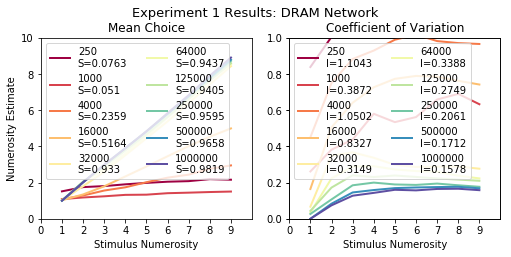

Sharon 8/29/19 image_title: Experiment 1 Results DRAM Network
data/DRAM_classify_blobs_2/expt1draw
Done making vectors csv file!
data/DRAM_classify_blobs_2/DRAM_cv_intercepts
Done making data/DRAM_classify_blobs_2/DRAM_cv_intercepts csv file!


In [22]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: DRAM Network", all_iters_same_row=True)
make_vectors_csv(data_directory + "expt1draw", cmus, ccvs, all_iters, iter_indices)
make_cv_intercept_csv_expt1(data_directory + "DRAM_cv_intercepts", ccvs, all_iters)

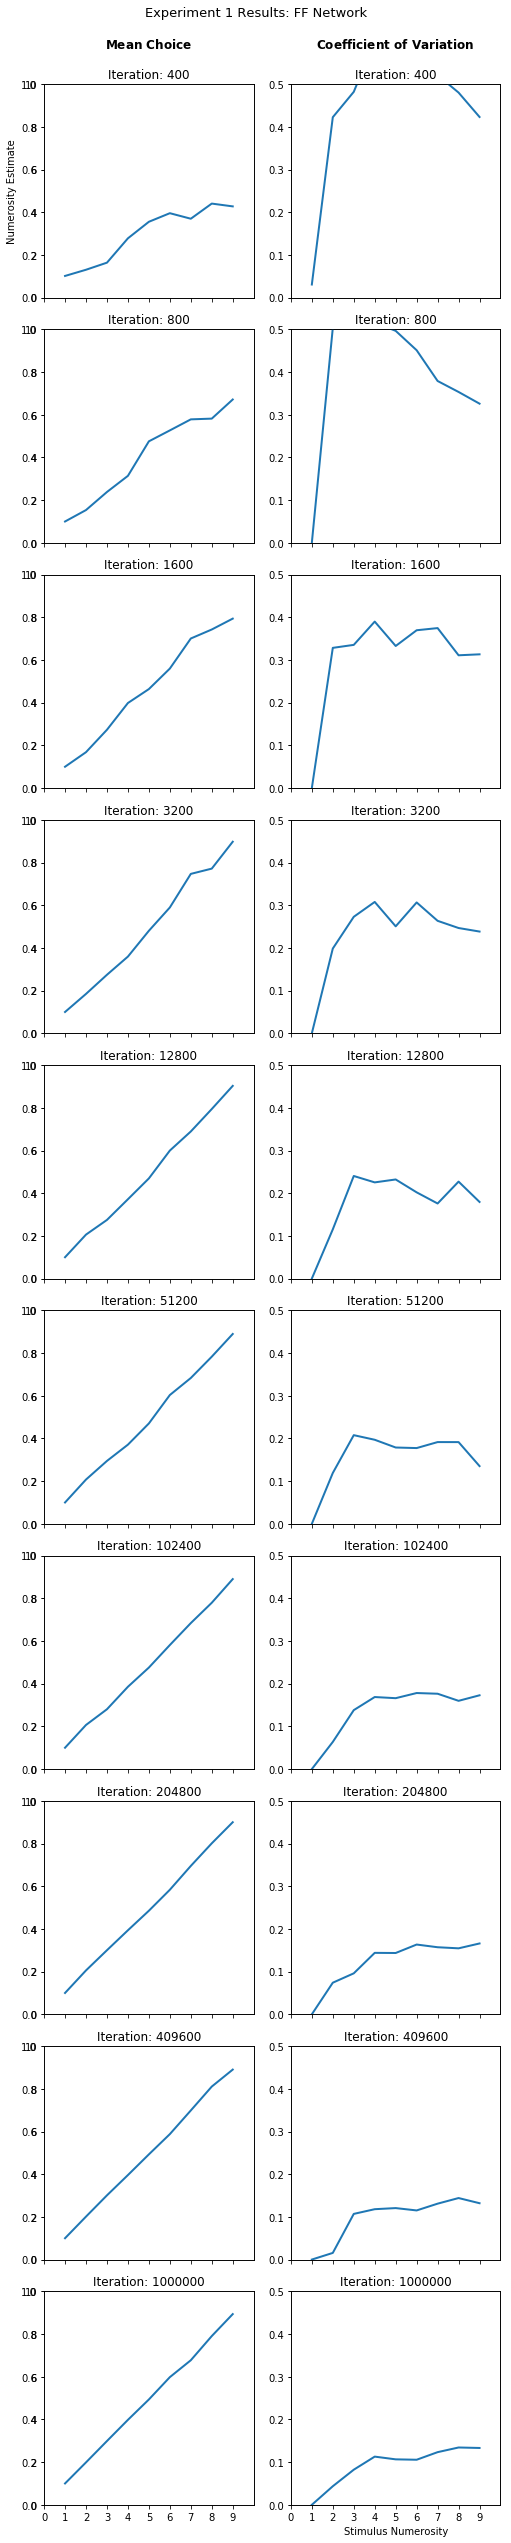

Sharon 8/29/19 image_title: Experiment 1 Results FF Network
data/DRAM_onelayer/expt1ff
Done making vectors csv file!
data/DRAM_onelayer/expt1ff_cmus
Done making cmus csv file!
data/DRAM_onelayer/FF_cv_intercepts
Done making data/DRAM_onelayer/FF_cv_intercepts csv file!


In [23]:
model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 800, 1600, 3200, 12800, 51200, 102400, 204800, 409600, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: FF Network")
make_vectors_csv(data_directory + "expt1ff", cmus, ccvs, all_iters, iter_indices)
make_cmus_csv(data_directory + "expt1ff_cmus", cmus, 1)
make_cv_intercept_csv_expt1(data_directory + "FF_cv_intercepts", ccvs, all_iters)

## View Essential Time Points

### Development Graphs for Experiment 1

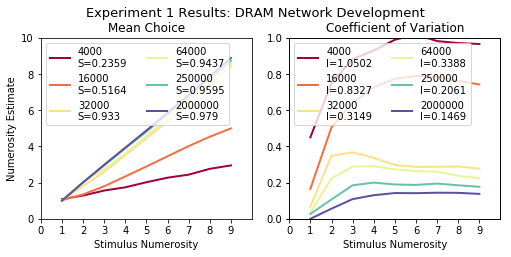

Sharon 8/29/19 image_title: Experiment 1 Results DRAM Network Development


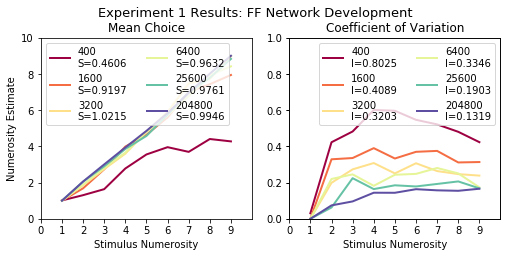

Sharon 8/29/19 image_title: Experiment 1 Results FF Network Development


(<matplotlib.figure.Figure at 0x7fc73ba2a6a0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc73b259a20>,
       dtype=object))

In [24]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [4000, 16000, 32000, 64000, 250000, 2000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: DRAM Network Development", all_iters_same_row=True)

model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 1600, 3200, 6400, 25600, 204800]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: FF Network Development", all_iters_same_row=True)

### Development and Final Performance Graphs for FF Estimation 6/5/19

In [25]:
if False:
    ff_est_model_names = ["DAA_const_fN_5layer", "DAA_decrs_fN_5layer", "DAA_const_fN_5layer_250", "DAA_decrs_fN_5layer_250"]

    for model_name in ff_est_model_names:
        data_directory = "data/" + model_name + "/"
        all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
        iters = [6400, 25600, 102400, 409600, 1000000, 3000000]
        iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
        plot_stats(cm, all_iters, iter_indices, model_name + " FF Network Development", all_iters_same_row=True)

    for model_name in ff_est_model_names:
        data_directory = "data/" + model_name + "/"
        all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
        iters = [3000000]
        iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
        plot_stats(cm, all_iters, iter_indices, model_name + " FF Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True, show_key=False)

### Development and Final Performance Graphs for FF Estimation 6/18/19
- 6/18/19: Update plot_stats to save figure in "Results/20190619_FF_estimation/"
- 7/1/19: with different timesteps
- 7/2/19: with CAA, Update plot_stats to save figure in "Results/20190702_FF_estimation/"

In [26]:
if False:
    ff_est_model_names = ["New_CAA_const_fN", "New_CAA_decrs_fN"]

    for model_name in ff_est_model_names:
        data_directory = "data/" + model_name + "/"
        all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
        iters = [200, 400, 1600, 102400, 1000000, 3000000]
        iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
        plot_stats(cm, all_iters, iter_indices, model_name + " FF Network Development", all_iters_same_row=True)

    for model_name in ff_est_model_names:
        data_directory = "data/" + model_name + "/"
        all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
        iters = [3000000]
        iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
        plot_stats(cm, all_iters, iter_indices, model_name + " FF Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True, show_key=False)

### Final Performance Graphs for Experiment 1

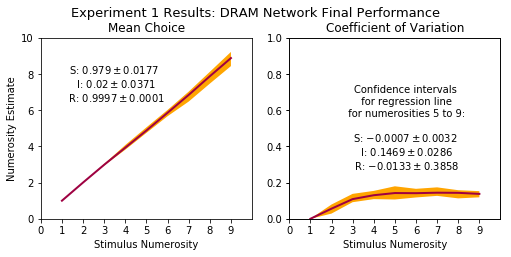

Sharon 8/29/19 image_title: Experiment 1 Results DRAM Network Final Performance


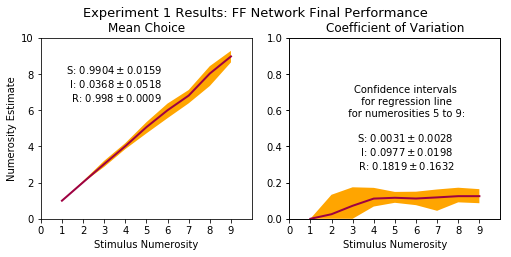

Sharon 8/29/19 image_title: Experiment 1 Results FF Network Final Performance


(<matplotlib.figure.Figure at 0x7fc73b057ba8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc73aa7f3c8>,
       dtype=object))

In [27]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [2000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: DRAM Network Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True, show_key=False) #SHARON take out key


model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [3000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
plot_stats(cm, all_iters, iter_indices, "Experiment 1 Results: FF Network Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True, show_key=False) #SHARON take out key

# Experiment 2

In [28]:
final_iter = 3000000 # 20190710 Sharon

In [29]:
cm = np.load("data/" + "New_DAA_decrs_fN" + "/" + 'choice_msdcv_fh.npy')[:,:,:max_blobs+1,:]

In [30]:
cm[:, :, 0, :]

array([[[8.32799983e+00, 2.65488528e+00, 3.18790266e-01],
        [1.13399998e+00, 4.89942849e-01, 4.32048376e-01],
        [1.01399998e+00, 1.17490424e-01, 1.15868271e-01],
        [1.05999998e+00, 2.37486839e-01, 2.24044193e-01],
        [1.01999998e+00, 1.39999999e-01, 1.37254903e-01],
        [1.00599998e+00, 7.72269375e-02, 7.67663410e-02],
        [1.01999998e+00, 1.39999999e-01, 1.37254903e-01],
        [1.01999998e+00, 1.39999999e-01, 1.37254903e-01],
        [1.00399998e+00, 6.31189347e-02, 6.28674661e-02],
        [1.02599998e+00, 1.59135161e-01, 1.55102499e-01],
        [1.00599998e+00, 7.72269375e-02, 7.67663410e-02],
        [1.00399998e+00, 6.31189347e-02, 6.28674661e-02],
        [1.00199998e+00, 4.46766154e-02, 4.45874414e-02],
        [1.00199998e+00, 4.46766154e-02, 4.45874414e-02],
        [9.99999980e-01, 1.99999993e-08, 1.99999997e-08]],

       [[7.11799986e+00, 3.41175553e+00, 4.79313795e-01],
        [1.09599998e+00, 5.82051538e-01, 5.31068932e-01],
        [1.0

In [31]:
from itertools import cycle
def plot_expt2_stats(model_name, test_group, title, iters=[final_iter], fig=None, ax=None,
                    show_cv_key=False, show_mu_key=False, move_text=True, num_key_cols=None,
                    show_iter_num=True, show_iter_label=False):
    """Plot the experiment 2 results."""
    
    data_directory = "data/" + model_name + "/"
    
    all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
    all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000] # Sharon 20190708
    iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
    show_CIs = len(iters) is 1
    #print(show_CIs)
    show_cta_caa_avg_key = len(iters) is 1 #SHARON
    show_test_group = diff_styles = len(iters) > 1 #SHARON
    show_avg_key = len(iters) > 1 #SHARON

    if test_group is "fh" or test_group is "cta": # first half of test stimulus have constant total area
        cm = np.load(data_directory + 'choice_msdcv_fh.npy')[:,:,:max_blobs+1,:max_blobs+1]
    elif test_group is "lh" or test_group is "caa": # last half of test stimulus have constant average area
        cm = np.load(data_directory + 'choice_msdcv_lh.npy')[:,:,:max_blobs+1,:max_blobs+1]
    elif test_group is "training":
        cm = np.load(data_directory + 'choice_msdcv_training.npy')[:,:,:max_blobs+1,:max_blobs+1]
    elif test_group is "avg":
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:max_blobs+1,:max_blobs+1]
    elif test_group is "has_spacing":
        cm = np.load(data_directory + 'choice_msdcv_has_spacing_margin.npy')[:,:,:max_blobs+1,:max_blobs+1]
    elif test_group is "all":
        cm_fh = np.load(data_directory + 'choice_msdcv_fh.npy')[:,:,:max_blobs+1,:max_blobs+1]
        fig, ax = plot_stats(cm_fh, all_iters, iter_indices, title, all_iters_same_row=True,
                             show_plot=False, linestyle='b-', linewidth=0.5, move_text=move_text, show_key=False,
                             show_test_group=show_test_group, test_group="CTA", diff_styles=diff_styles,
                             show_cv_key=show_cv_key, show_mu_key=show_mu_key, num_key_cols=num_key_cols,
                             show_iter_num=show_iter_num, show_iter_label=show_iter_label,
                             show_cta_caa_avg_key=show_cta_caa_avg_key, show_S=False, show_I=False,
                             show_avg_key=show_avg_key)
        cm_lh = np.load(data_directory + 'choice_msdcv_lh.npy')[:,:,:max_blobs+1,:max_blobs+1]
        plot_stats(cm_lh, all_iters, iter_indices, title, all_iters_same_row=True, fig=fig, ax=ax,
                   show_plot=False, linestyle='r-', linewidth=0.5, move_text=move_text, show_key=False,
                   show_test_group=show_test_group, test_group="CAA", diff_styles=diff_styles,
                   show_cv_key=show_cv_key, show_mu_key=show_mu_key, num_key_cols=num_key_cols,
                   show_iter_num=show_iter_num, show_iter_label=show_iter_label,
                   show_cta_caa_avg_key=show_cta_caa_avg_key, show_S=False, show_I=False,
                   show_avg_key=show_avg_key)
        cm_training = np.load(data_directory + 'choice_msdcv_training.npy')[:,:,:max_blobs+1,:max_blobs+1]
        plot_stats(cm_training, all_iters, iter_indices, title, all_iters_same_row=True, fig=fig, ax=ax,
                   show_plot=False, linestyle='g-', linewidth=0.5, move_text=move_text, show_key=False,
                   show_test_group=show_test_group, test_group="Training", diff_styles=diff_styles,
                   show_cv_key=show_cv_key, show_mu_key=show_mu_key, num_key_cols=num_key_cols,
                   show_iter_num=show_iter_num, show_iter_label=show_iter_label,
                   show_cta_caa_avg_key=show_cta_caa_avg_key, show_S=False, show_I=False, show_CIs=False,
                   show_avg_key=show_avg_key)
        cm_has_spacing = np.load(data_directory + 'choice_msdcv_has_spacing_margin.npy')[:,:,:max_blobs+1,:max_blobs+1]
        plot_stats(cm_has_spacing, all_iters, iter_indices, title, all_iters_same_row=True, fig=fig, ax=ax,
                   show_plot=False, linestyle='o-', linewidth=0.5, move_text=move_text, show_key=False,
                   show_test_group=show_test_group, test_group="CTA2", diff_styles=diff_styles,
                   show_cv_key=show_cv_key, show_mu_key=show_mu_key, num_key_cols=num_key_cols,
                   show_iter_num=show_iter_num, show_iter_label=show_iter_label,
                   show_cta_caa_avg_key=show_cta_caa_avg_key, show_S=False, show_I=False, show_CIs=True,
                   show_avg_key=show_avg_key)
        cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:max_blobs+1,:]
        # show_CIs should be show_CIs, setting it to False now
        plot_stats(cm, all_iters, iter_indices, title, all_iters_same_row=True, show_CIs=False,
                   fig=fig, ax=ax, linestyle='k-', move_text=move_text,
                   show_test_group=True, test_group="Avg", diff_styles=diff_styles,
                   show_cv_key=show_cv_key, show_mu_key=show_mu_key, num_key_cols=num_key_cols,
                   show_iter_num=show_iter_num, show_iter_label=show_iter_label,
                   show_cta_caa_avg_key=show_cta_caa_avg_key, show_S=False, show_I=False,
                   show_avg_key=show_avg_key)
        

        return fig, ax
 
    
    if test_group is not "all":
        plot_stats(cm, all_iters, iter_indices, title, all_iters_same_row=True, show_CIs=show_CIs,
                   show_iter_num=show_iter_num, show_iter_label=show_iter_label)


In [32]:
def create_expt2_panel(model_name, title, iters=[final_iter]):
    """Create panel of all the expt 2 stats."""
    
    plot_expt2_stats(model_name, "avg", title + ", Final Performance", show_iter_num=False)
    plot_expt2_stats(model_name, "cta", title + ", CTA, Final Performance", show_iter_num=False)
    plot_expt2_stats(model_name, "caa", title + ", CAA, Final Performance", show_iter_num=False)
    plot_expt2_stats(model_name, "training", title + ", Training Data, Final Performance", show_iter_num=False)
    
    plot_expt2_stats(model_name, "avg", title + ", Development", iters=iters)
    plot_expt2_stats(model_name, "cta", title + ", CTA, Development", iters=iters)
    plot_expt2_stats(model_name, "caa", title + ", CAA, Development", iters=iters)
    plot_expt2_stats(model_name, "training", title + ", Development", iters=iters)
    
def create_expt2_single(model_name, title, iters=[final_iter]):
    """Create panel of all the expt 2 stats."""
    
    plot_expt2_stats(model_name, "cta", title + ", CTA, Final Performance", show_iter_num=False)
    plot_expt2_stats(model_name, "caa", title + ", CAA, Final Performance", show_iter_num=False)
    
    plot_expt2_stats(model_name, "cta", title + ", CTA, Development", iters=iters)
    plot_expt2_stats(model_name, "caa", title + ", CAA, Development", iters=iters)
    

def create_expt2_merged_panel(model_name, title, iters=[final_iter], move_text=True):
    """Create panel of all the expt 2 stats."""
    
    plot_expt2_stats(model_name, "all", title + ", Final Performance",
                     show_iter_num=False, show_mu_key=True, num_key_cols=1, move_text=move_text) # move_text=False only for row 4 (second row of Experiment 2)
    plot_expt2_stats(model_name, "all", title + ", Final Performance",
                     show_iter_num=False, show_cv_key=True, num_key_cols=1, move_text=True)

    plot_expt2_stats(model_name, "all", title + ", Development",
                     iters=iters, show_mu_key=True, num_key_cols=2)
    plot_expt2_stats(model_name, "all", title + ", Development",
                     iters=iters, show_cv_key=True, num_key_cols=2)

# Experiment 2 Preliminary Graphs

20190708 (Sharon): I change `iters`, and for each graph, I change the model to one that's trained with the new training data

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


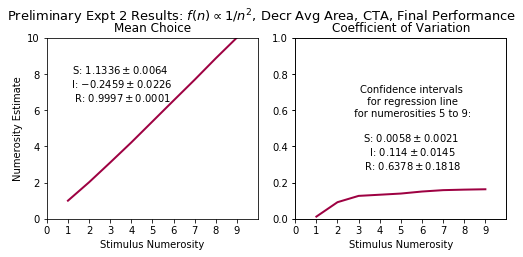

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CTA Final Performance


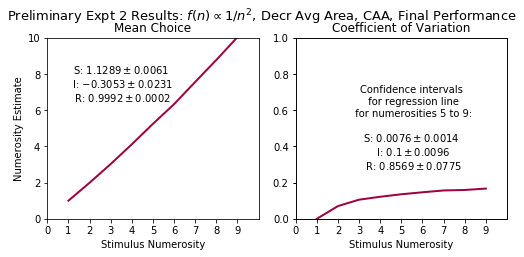

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CAA Final Performance


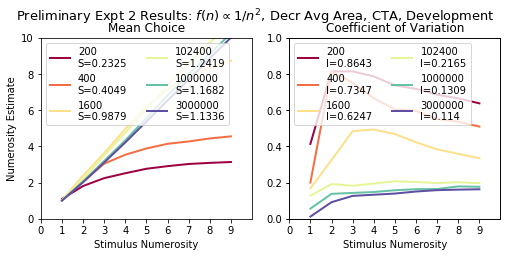

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CTA Development


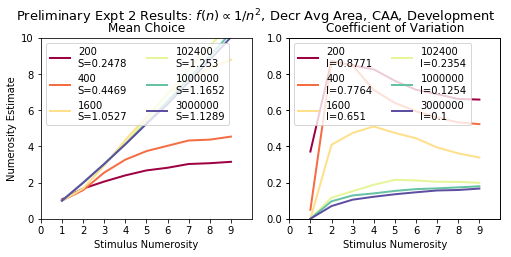

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CAA Development


In [33]:
if True:
    iters = [400, 800, 1600, 12800, 153600, 1000000]
    iters = [200, 400, 1600, 102400, 1000000, 3000000] #Sharon 20190708
    create_expt2_single("New_DAA_decrs_fN",
                       "Preliminary Expt 2 Results: $f(n) \propto 1/n^2$, Decr Avg Area",
                       iters=iters)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


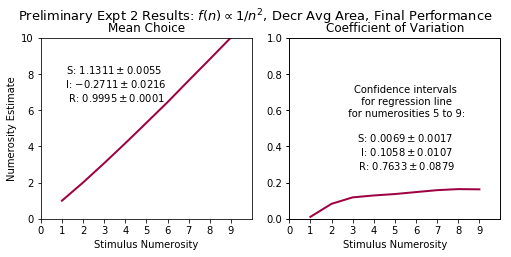

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance


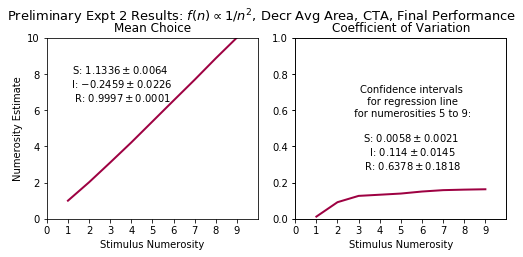

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CTA Final Performance


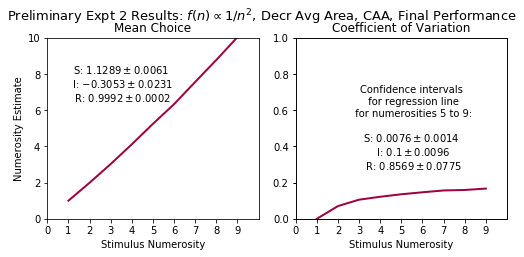

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CAA Final Performance


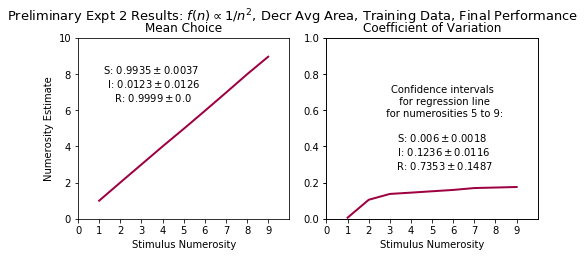

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area Training Data Final Performance


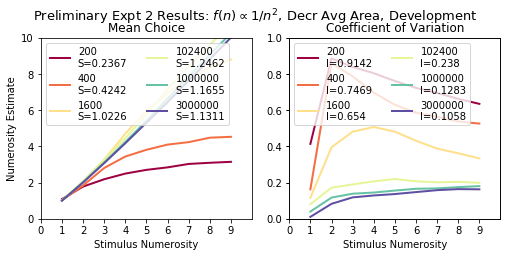

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area Development


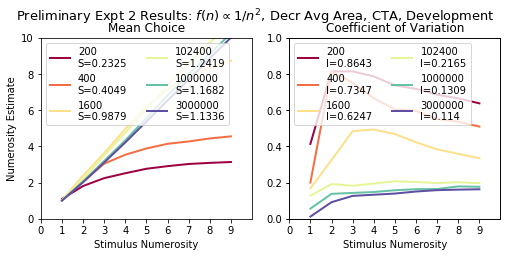

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CTA Development


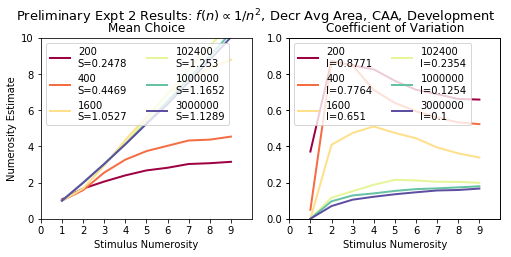

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area CAA Development


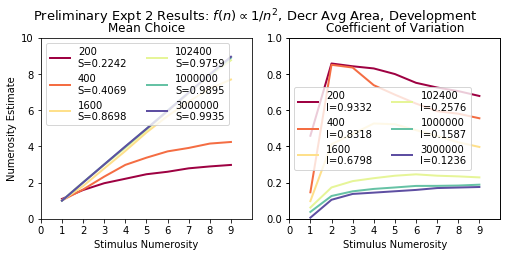

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Decr Avg Area Development


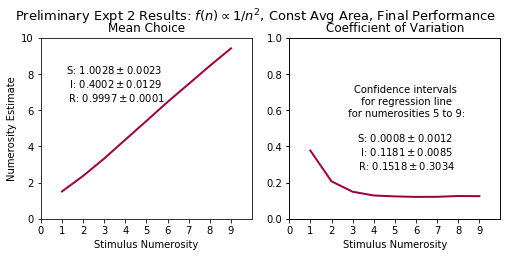

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area Final Performance


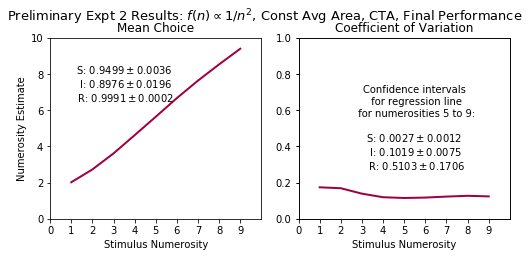

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area CTA Final Performance


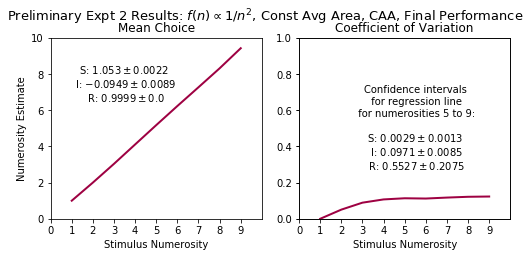

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area CAA Final Performance


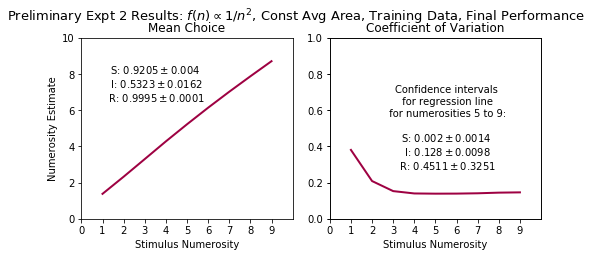

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area Training Data Final Performance


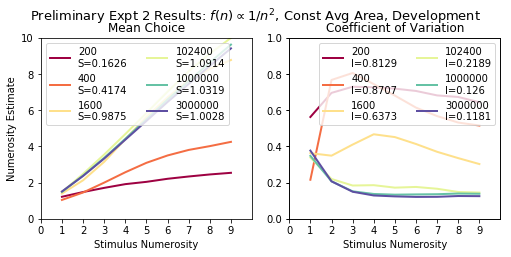

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area Development


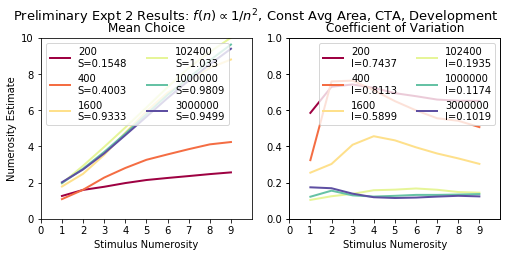

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area CTA Development


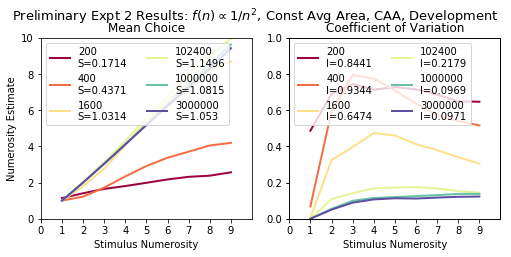

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area CAA Development


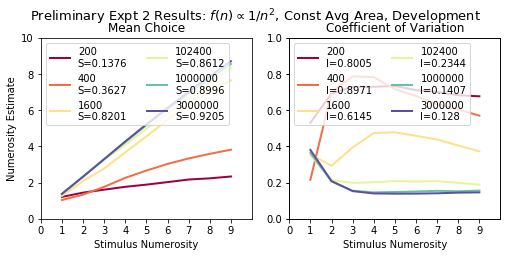

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn propto 1n2 Const Avg Area Development


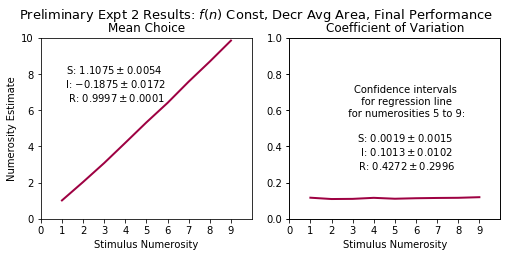

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area Final Performance


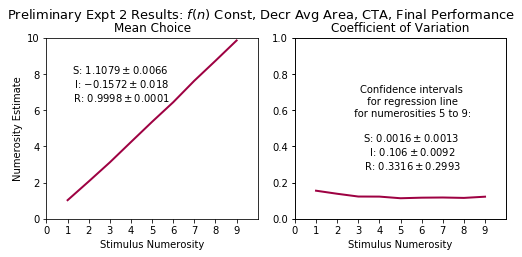

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area CTA Final Performance


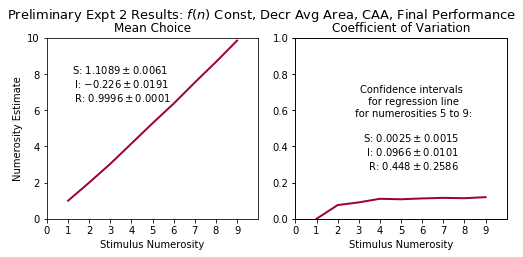

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area CAA Final Performance


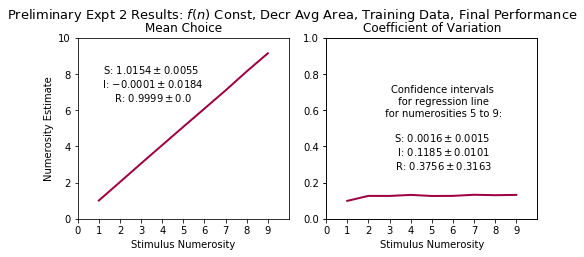

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area Training Data Final Performance


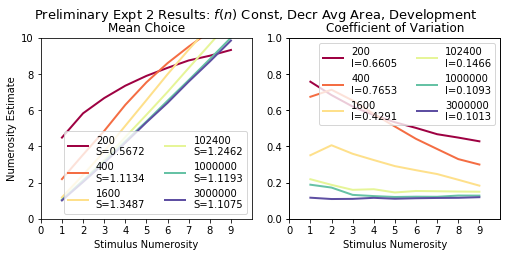

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area Development


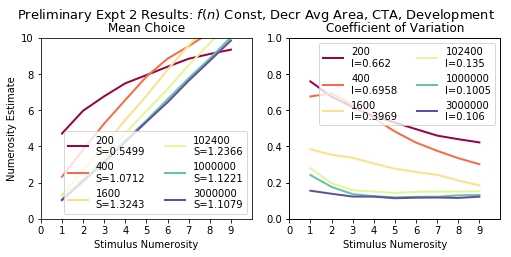

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area CTA Development


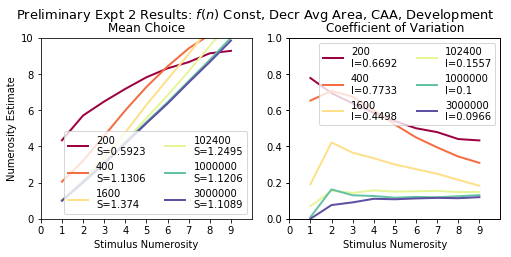

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area CAA Development
Preliminary Expt 2 Results fn Const Decr Avg Area CAA Development


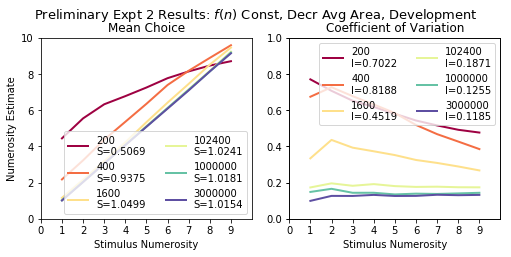

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Decr Avg Area Development


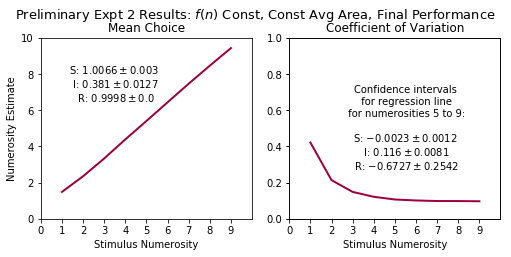

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area Final Performance


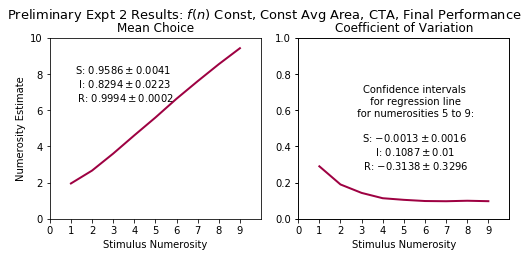

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area CTA Final Performance


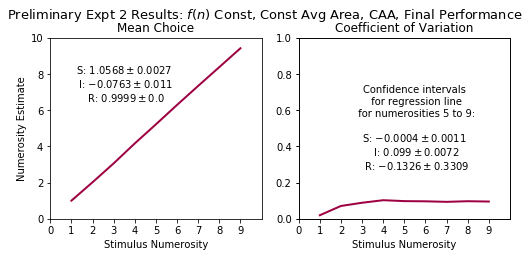

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area CAA Final Performance


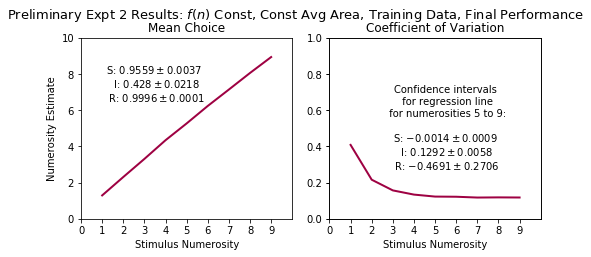

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area Training Data Final Performance


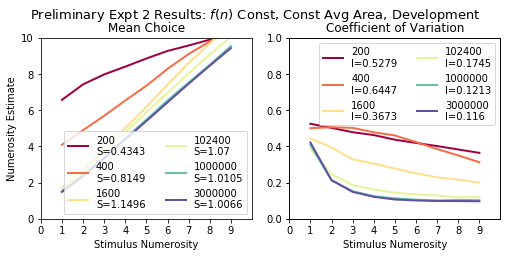

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area Development
Preliminary Expt 2 Results fn Const Const Avg Area Development


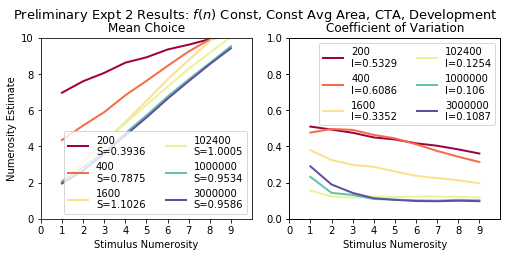

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area CTA Development


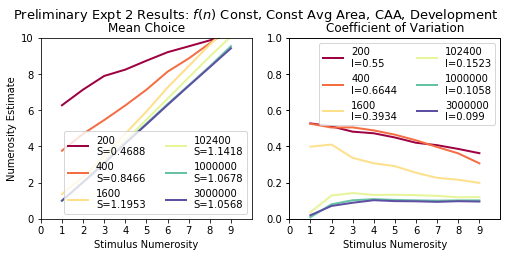

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area CAA Development


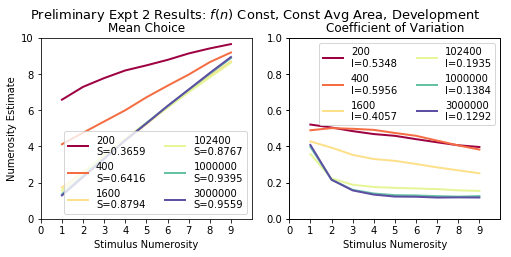

Sharon 8/29/19 image_title: Preliminary Expt 2 Results fn Const Const Avg Area Development


In [34]:
if True:
    iters = [400, 800, 1600, 12800, 153600, 1000000]
    iters = [200, 400, 1600, 102400, 1000000, 3000000] #Sharon 20190708
    create_expt2_panel("New_DAA_decrs_fN",
                       "Preliminary Expt 2 Results: $f(n) \propto 1/n^2$, Decr Avg Area",
                       iters=iters)
    create_expt2_panel("New_CAA_decrs_fN",
                       "Preliminary Expt 2 Results: $f(n) \propto 1/n^2$, Const Avg Area",
                       iters=iters)
    create_expt2_panel("New_DAA_const_fN",
                       "Preliminary Expt 2 Results: $f(n)$ Const, Decr Avg Area",
                       iters=iters)
    create_expt2_panel("New_CAA_const_fN",
                       "Preliminary Expt 2 Results: $f(n)$ Const, Const Avg Area",
                       iters=iters)

# Experiment 2 Panels

Ignore graphs that are on the right column!

In [35]:
iters = [400, 6400, 1600] #add 6400 to show how quickly near-final performance is reached SHARON

### Final Performance and Development Graphs for CAA, with $f(n) \propto 1/n^2$

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance


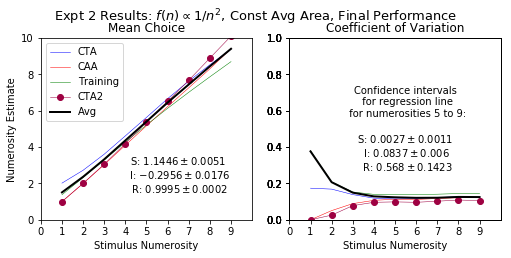

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance
Expt 2 Results fn propto 1n2 Const Avg Area Final Performance


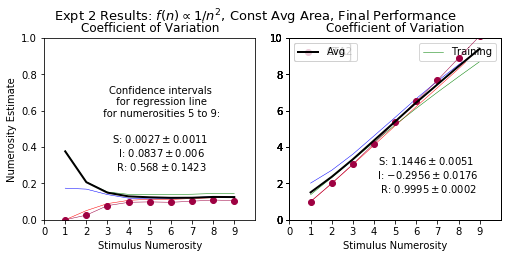

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Final Performance


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development


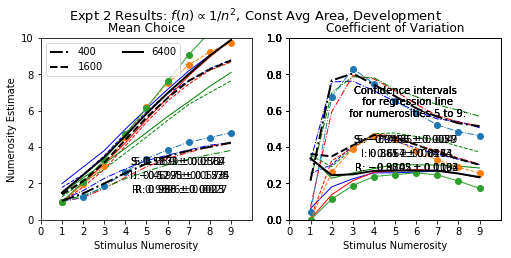

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development


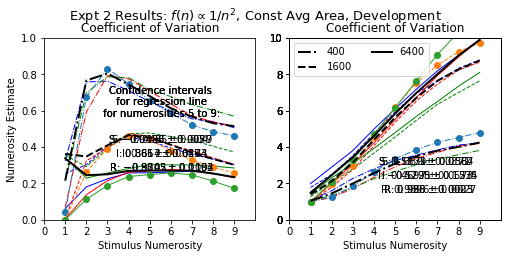

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Const Avg Area Development


In [36]:
create_expt2_merged_panel("New_CAA_decrs_fN",
                   "Expt 2 Results: $f(n) \propto 1/n^2$, Const Avg Area",
                   iters=iters)

### Final Performance and Development Graphs for CAA, with $f(n) \propto n$

Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance


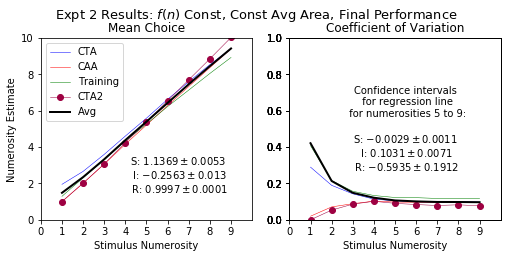

Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance


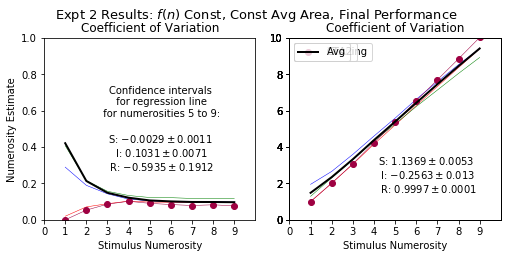

Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Final Performance


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development


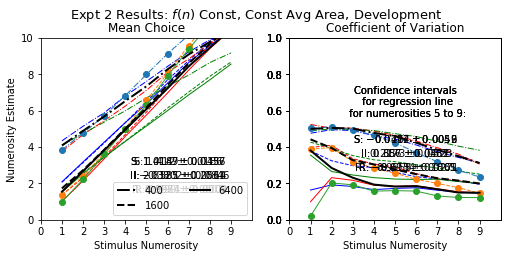

Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development


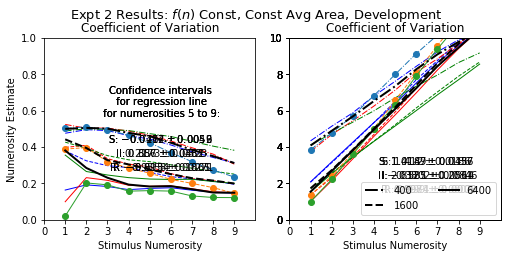

Sharon 8/29/19 image_title: Expt 2 Results fn Const Const Avg Area Development


In [37]:
create_expt2_merged_panel("New_CAA_const_fN",
                   "Expt 2 Results: $f(n)$ Const, Const Avg Area",
                   iters=iters, move_text=True) # SHARON 7/9/18

### Final Performance and Development Graphs for DAA, with $f(n) \propto 1/n^2$

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance


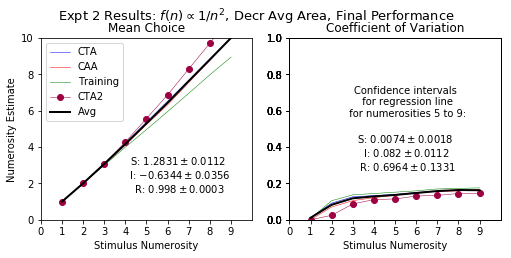

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance


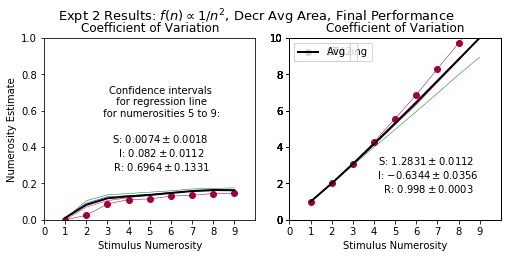

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Final Performance


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development


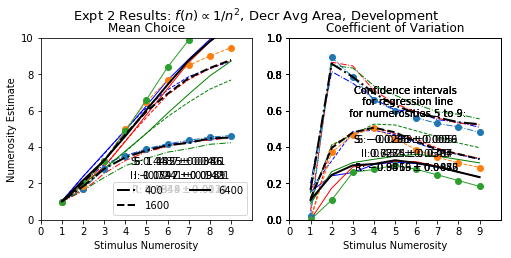

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development


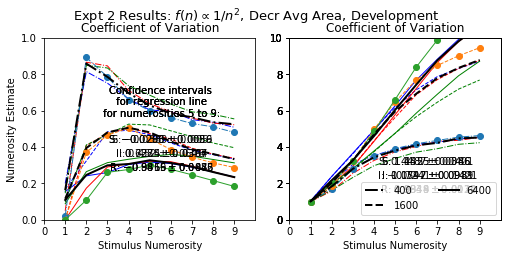

Sharon 8/29/19 image_title: Expt 2 Results fn propto 1n2 Decr Avg Area Development


In [38]:
create_expt2_merged_panel("New_DAA_decrs_fN",
                   "Expt 2 Results: $f(n) \propto 1/n^2$, Decr Avg Area",
                   iters=iters)

### Final Performance and Development Graphs for DAA, with $f(n) \propto n$

Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance


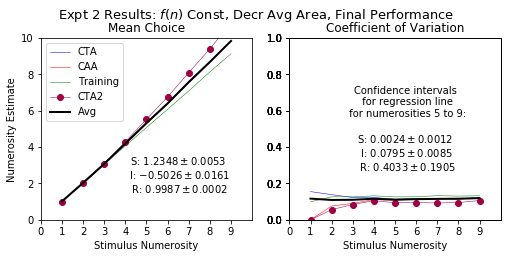

Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance


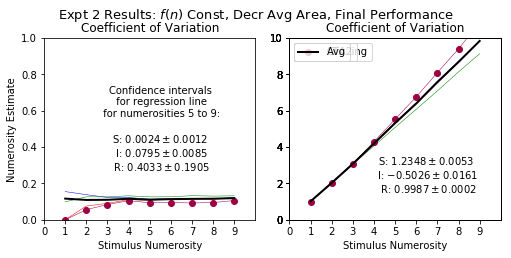

Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Final Performance


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development


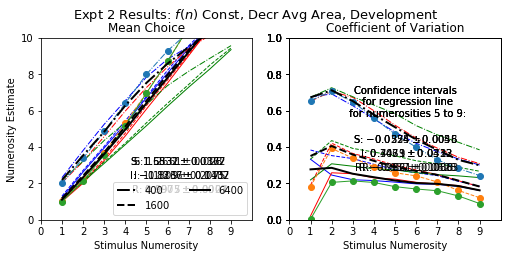

Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development
Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development


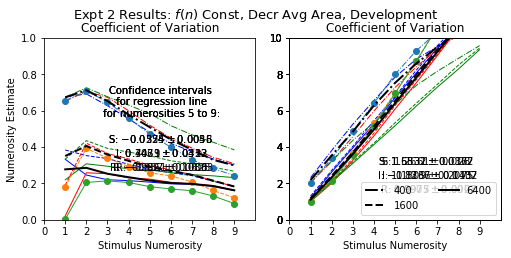

Sharon 8/29/19 image_title: Expt 2 Results fn Const Decr Avg Area Development


In [39]:
create_expt2_merged_panel("New_DAA_const_fN",
                   "Expt 2 Results: $f(n)$ Const, Decr Avg Area",
                   iters=iters)

In [40]:
all_iters = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
ccvs_dict = {}

FF_networks = {
    "New_CAA_decrs_fN": "DF_CAA",
    "New_CAA_const_fN": "CF_CAA",
    "New_DAA_decrs_fN": "DF_DAA",
    "New_DAA_const_fN": "CF_DAA"
}

for model_name in FF_networks:
    data_directory = "data/" + model_name + "/"
    cm_fh = np.load(data_directory + 'choice_msdcv_fh.npy')[:,:,:10,:]
    cm_lh = np.load(data_directory + 'choice_msdcv_lh.npy')[:,:,:10,:]
    cm = (np.array(cm_fh) + np.array(cm_lh)) / 2.0
    cmus = cm[:,:,:,0] # mean
    ccvs = cm[:,:,:,2] # cv
    ccvs_dict[FF_networks[model_name]] = ccvs
    make_cmus_csv(data_directory + "expt2_cmus_" + FF_networks[model_name], cmus, 1)

print(ccvs_dict)
make_cv_intercept_csv_expt2("data/20190829_FF_estimation_final_iter_3000000_expt2_cv_intercepts_has_spacing", ccvs_dict, all_iters)


data/New_CAA_const_fN/expt2_cmus_CF_CAA
Done making cmus csv file!
data/New_CAA_decrs_fN/expt2_cmus_DF_CAA
Done making cmus csv file!
data/New_DAA_const_fN/expt2_cmus_CF_DAA
Done making cmus csv file!
data/New_DAA_decrs_fN/expt2_cmus_DF_DAA
Done making cmus csv file!
{'CF_CAA': array([[[0.41453469, 0.43670228, 0.45397613, ..., 0.42120043,
         0.4430753 , 0.43261757],
        [0.54193913, 0.50769992, 0.4723548 , ..., 0.37622184,
         0.36857783, 0.34535194],
        [0.59916305, 0.54995977, 0.51665011, ..., 0.35074074,
         0.30190437, 0.27879892],
        ...,
        [0.13772413, 0.11751437, 0.12198685, ..., 0.10344228,
         0.09503661, 0.08771449],
        [0.16424101, 0.12914442, 0.123688  , ..., 0.10469243,
         0.08888981, 0.08845568],
        [0.14715963, 0.11969886, 0.12303694, ..., 0.097099  ,
         0.09159884, 0.09056487]],

       [[0.4443887 , 0.40180809, 0.42768331, ..., 0.38068107,
         0.38896181, 0.39010737],
        [0.48398445, 0.48260171, 0